In [96]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import geoplot as gplt

In [123]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
conf = pd.read_csv(url + 'time_series_19-covid-Confirmed.csv')
dead = pd.read_csv(url + 'time_series_19-covid-Deaths.csv')
recs = pd.read_csv(url + 'time_series_19-covid-Recovered.csv')

In [124]:
conf.head(n=100)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,50,53,59,70,75,82,114,147,177,212
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,511,581,639,639,701,773,839,825,878,889
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,150,160,178,178,200,212,226,243,266,313
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,117,129,149,149,197,238,428,566,673,790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,2,10,12,23,33,38,42,51,55,59
96,NaN,Cyprus,35.1264,33.4299,0,0,0,0,0,0,...,2,3,6,6,14,26,26,33,46,49
97,NaN,Brunei,4.5353,114.7277,0,0,0,0,0,0,...,1,1,11,11,37,40,50,54,56,68
98,Washington,US,47.4009,-121.4905,0,0,0,0,0,0,...,0,267,366,442,568,572,643,904,1076,1014


In [83]:
plot_data = conf.loc[conf['Country/Region'] == 'US']

In [84]:
plot_data

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20
98,Washington,US,47.4009,-121.4905,0,0,0,0,0,0,...,0,267,366,442,568,572,643,904,1076,1014
99,New York,US,42.1657,-74.9481,0,0,0,0,0,0,...,0,173,220,328,421,525,732,967,1706,2495
100,California,US,36.1162,-119.6816,0,0,0,0,0,0,...,0,144,177,221,282,340,426,557,698,751
101,Massachusetts,US,42.2302,-71.5301,0,0,0,0,0,0,...,0,92,95,108,123,138,164,197,218,218
102,Diamond Princess,US,35.4437,139.6380,0,0,0,0,0,0,...,45,46,46,46,46,46,46,47,47,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,"New Castle, DE",US,39.5393,-75.6674,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
414,Alabama,US,32.3182,-86.9023,0,0,0,0,0,0,...,0,0,0,0,5,6,12,29,39,46
417,Puerto Rico,US,18.2208,-66.5901,0,0,0,0,0,0,...,0,0,0,0,0,3,5,5,5,5
431,Guam,US,13.4443,144.7937,0,0,0,0,0,0,...,0,0,0,0,0,0,3,3,3,5


In [106]:
state_ind = plot_data['Province/State'].apply(lambda x: ',' not in x)

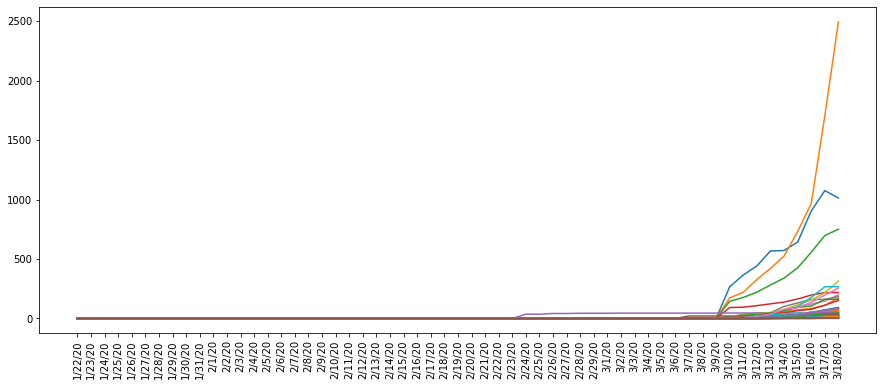

In [115]:
fig,ax=plt.subplots(figsize=(15,6))

plt.plot(plot_data[state_ind].iloc[:,4:].transpose())
#plt.legend(plot_data[state_ind]['Province/State'])
_ = plt.xticks(rotation=90)

In [ ]:
plt.plot(conf.groupby('Province/State').sum().loc['Alameda County, CA'].iloc[2:])

In [ ]:
conf.groupby('Province/State').sum()